In [2]:
# Importing needed libraries
import os
import pandas as pd
import cv2
import mediapipe as mp
from mediapipe.tasks.python import vision
from multiprocessing import Pool, cpu_count
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from keras.src.callbacks import ReduceLROnPlateau
from keras.src.models import Model
from keras.src.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout, Concatenate ,Input


In [3]:
# Setting the path to the data
path = os.path.abspath('..')

train_path = os.path.join(path, 'dataset', 'ASL_Dataset', 'Train')
test_path = os.path.join(path, 'dataset', 'ASL_Dataset', 'Test')
model_path = os.path.join(path, 'models' ,'hand_landmarker.task')

In [4]:
# Label map
label_map = {chr(i): i - ord('A') for i in range(ord('A'), ord('Z') + 1)}
label_map['Nothing'] = 26
label_map['Space'] = 27
# Utils functions
def set_to_csv(input, output):
    # Initialize an empty list to store data
    data = []
    
    # Iterate through each subfolder in the training path
    for label_folder in sorted(os.listdir(input)):
        folder_path = os.path.join(input, label_folder)
        if os.path.isdir(folder_path) and label_folder in label_map:
            label = label_map[label_folder]
            # Iterate through each image file in the folder
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                # Read the image
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                # Resize to 50x50 pixels
                resized_image = cv2.resize(image, (50, 50))
                # Flatten the image to a 1D array
                flattened_image = resized_image.flatten()
                # Append the label and flattened image to the data
                data.append([label] + flattened_image.tolist())
    
    # Create a DataFrame with the data
    columns = ['Label'] + [f'Pixel_{i}' for i in range(50 * 50)]
    df = pd.DataFrame(data, columns=columns)
    
    # Save the DataFrame to a CSV file
    df.to_csv(output, index=False)
    
    print("CSV file with label mappings created successfully!")


BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the video mode:
options = HandLandmarkerOptions(
    num_hands=1,
    min_hand_detection_confidence=0.6,
    min_hand_presence_confidence=0.6,
    min_tracking_confidence=0.5,
    base_options=BaseOptions(model_asset_path='../models/hand_landmarker.task'),running_mode=VisionRunningMode.IMAGE)

# Function to process a single image
def process_image(task):
    label, image_path = task
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

    result = detector.detect(mp_image)

    if result.hand_landmarks:
        landmarks = result.hand_landmarks[0]
        landmark_list = []
        for lm in landmarks:
            landmark_list.extend([lm.x, lm.y])
        return [label] + landmark_list
    else:
        print(f"No hand landmarks detected in {image_path}")
        return None

def initialize_detector():
    global detector
    detector = vision.HandLandmarker.create_from_options(options)

def landmarks_to_csv(input, output):
    # Collect all image paths and labels
    tasks = []
    for label_folder in sorted(os.listdir(input)):
        folder_path = os.path.join(input, label_folder)
        if os.path.isdir(folder_path) and label_folder in label_map:
            label = label_map[label_folder]
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                tasks.append((label, image_path))
    
    print(f"Processing {len(tasks)} images...")

    # Use multiprocessing pool to process images in parallel
    if __name__ == '__main__':
        with Pool(processes=cpu_count(), initializer=initialize_detector) as pool:
            results = pool.map(process_image, tasks)

    # Filter out None results and prepare for CSV
    data = [result for result in results if result is not None]
    
    # Define column names
    num_landmarks = 21  # MediaPipe detects 21 landmarks per hand
    columns = ['Label'] + [f'X{i+1}' for i in range(num_landmarks)] + [f'Y{i+1}' for i in range(num_landmarks)]
    
    # Create a DataFrame and save it to a CSV file
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output, index=False)
    
    print("CSV file with hand landmarks created successfully!")


In [6]:
# Create CSV files for training and testing data
set_to_csv(train_path, '../dataset/train.csv')
set_to_csv(test_path, '../dataset/test.csv')

KeyboardInterrupt: 

In [ ]:
landmarks_to_csv(train_path, '../dataset/train_landmarks.csv')
landmarks_to_csv(test_path, '../dataset/test_landmarks.csv')

Processing 165670 images...


I0000 00:00:1731868448.321724   12632 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731868448.362746   12632 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:194) surface_ != EGL_NO_SURFACEeglCreatePbufferSurface() returned error 0x3003
malloc(): unaligned tcache chunk detected
I0000 00:00:1731868448.368636   12632 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731868448.400764   12632 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:194) surface_ != EGL_NO_SURFACEeglCreatePbufferSurface() returned error 0x3003
malloc(): unaligned tcache chunk detected
I0000 00:00:1731868448.413801   12632 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731868448.458525   12632 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731868448.5

In [5]:
# Read the CSV files
train_landmarks_df = pd.read_csv('../dataset/train_landmarks.csv')
test_landmarks_df = pd.read_csv('../dataset/test_landmarks.csv')

train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')


In [6]:
train_df.head()

,Label,Pixel_0,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,...,Pixel_2490,Pixel_2491,Pixel_2492,Pixel_2493,Pixel_2494,Pixel_2495,Pixel_2496,Pixel_2497,Pixel_2498,Pixel_2499
0,0,172,170,170,171,172,170,171,172,171,...,129,127,130,129,129,130,129,127,129,127
1,0,169,168,168,170,168,168,168,170,171,...,138,139,142,136,139,138,137,138,138,136
2,0,171,170,171,171,171,170,172,170,171,...,130,131,134,130,132,129,132,133,131,132
3,0,171,171,172,170,170,171,171,169,167,...,129,131,130,130,127,130,128,129,127,126
4,0,169,172,165,168,170,170,171,170,169,...,140,142,143,142,141,140,139,138,140,134


In [7]:
train_landmarks_df.head()

,Label,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,Y12,Y13,Y14,Y15,Y16,Y17,Y18,Y19,Y20,Y21
0,0,0.721519,0.864362,0.628021,0.817362,0.554319,0.720143,0.539833,0.618976,0.572683,...,0.733822,0.680883,0.799626,0.641260,0.803488,0.593115,0.793390,0.655220,0.787702,0.679787
1,0,0.497991,0.724514,0.353257,0.666545,0.240426,0.523241,0.204762,0.386254,0.221443,...,0.475627,0.453765,0.579817,0.419694,0.561734,0.338634,0.531753,0.432794,0.537420,0.469487
2,0,0.430489,0.904350,0.302668,0.844059,0.203314,0.725524,0.182757,0.603459,0.210888,...,0.419161,0.662944,0.516494,0.618968,0.504839,0.557386,0.483902,0.640557,0.488069,0.663627
3,0,0.455753,0.885081,0.336396,0.817470,0.235511,0.701206,0.215076,0.578370,0.269344,...,0.456656,0.629179,0.546054,0.594781,0.540694,0.532583,0.520408,0.616139,0.521592,0.638724
4,0,0.458983,0.703875,0.339260,0.641953,0.238374,0.526383,0.206045,0.411880,0.245141,...,0.451168,0.470747,0.554074,0.441737,0.523155,0.389023,0.496544,0.470306,0.511546,0.487558


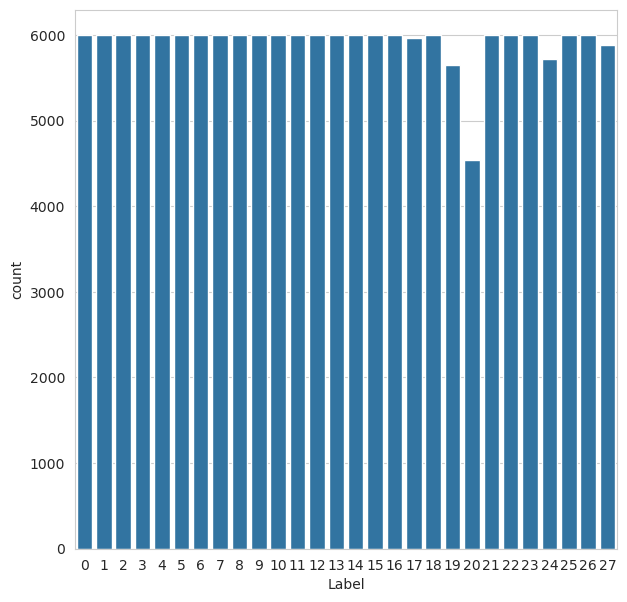

In [8]:
plt.figure(figsize = (7,7)) # Label Count
sns.set_style("whitegrid")
sns.countplot(x=train_df['Label'])
plt.show()

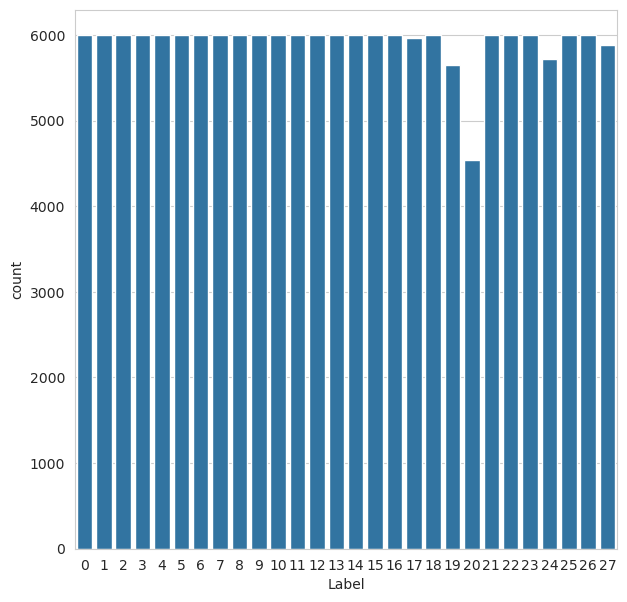

In [9]:
plt.figure(figsize = (7,7)) # Label Count
sns.set_style("whitegrid")
sns.countplot(x=train_landmarks_df['Label'])
plt.show()

In [10]:
# Splitting the data into features and labels
y_train = train_df['Label']
y_test = test_df['Label']

y_landmarks_train = train_landmarks_df['Label']
y_landmarks_test = test_landmarks_df['Label']

del train_df['Label']
del test_df['Label']
del train_landmarks_df['Label']
del test_landmarks_df['Label']

In [11]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)
y_landmarks_train = label_binarizer.fit_transform(y_landmarks_train)
y_landmarks_test = label_binarizer.fit_transform(y_landmarks_test)

In [12]:
# Extracting the features to numpy arrays
x_train = train_df.values
x_test = test_df.values

x_landmarks_train = train_landmarks_df.values
x_landmarks_test = test_landmarks_df.values

In [13]:
# Normalize the data because CNN converges faster on [0..1] data than on [0..255]
x_train = x_train / 255
x_test = x_test / 255


In [14]:
# Reshape the data to 3D matrices
x_train = x_train.reshape(-1, 50, 50, 1)
x_test = x_test.reshape(-1, 50, 50, 1)

x_landmarks_train = x_landmarks_train.reshape(-1, 21, 2, 1)
x_landmarks_test = x_landmarks_test.reshape(-1, 21, 2, 1)


In [15]:
# Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [17]:
# Building the model

# HEAD 1
image_input = Input(shape=(50,50,1), name='image_input')
h1 = Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(image_input)
h1 = BatchNormalization()(h1)
h1 = MaxPooling2D((2,2) , strides = 2 , padding = 'same')(h1)

h1 = Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(h1)
h1 = Dropout(0.2)(h1)
h1 = BatchNormalization()(h1)
h1 = MaxPooling2D((2,2) , strides = 2 , padding = 'same')(h1)

h1 = Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(h1)
h1 = Dropout(0.2)(h1)
h1 = BatchNormalization()(h1)
h1 = MaxPooling2D((2,2) , strides = 2 , padding = 'same')(h1)

h1 = Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(h1)
h1 = Dropout(0.2)(h1)
h1 = BatchNormalization()(h1)
h1 = MaxPooling2D((2,2) , strides = 2 , padding = 'same')(h1)

h1 = Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(h1)
h1 = Dropout(0.2)(h1)
h1 = BatchNormalization()(h1)
h1 = MaxPooling2D((2,2) , strides = 2 , padding = 'same')(h1)

h1 = Flatten()(h1)

# HEAD 2
landmarks_input = Input(shape=(21,2,1), name='landmarks_input')
h2 = Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(landmarks_input)
h2 = BatchNormalization()(h2)
h2 = MaxPooling2D((2,2) , strides = 2 , padding = 'same')(h2)

h2 = Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(h2)
h2 = BatchNormalization()(h2)
h2 = MaxPooling2D((2,2) , strides = 2 , padding = 'same')(h2)
h2 = Dropout(0.2)(h2)

h2 = Flatten()(h2)

# Concatenate the outputs of both branches
combined = Concatenate()([h1, h2])

h = Dense(512, activation='relu')(combined)
h = Dropout(0.2)(h)
h = Dense(28, activation='softmax')(h)

model = Model(inputs=[image_input, landmarks_input], outputs=h)
model.compile(optimizer = 'adam' , loss = 'mean_squared_error' , metrics = ['accuracy'])
model.summary(print_fn=print)


Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 50, 50, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 50, 50,    │        640 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 50,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 25,    │          0 │

In [18]:
# Train the model
history = model.fit(
    [x_train, x_landmarks_train],  # Inputs
    y_train,               # Labels
    validation_data=([x_test, x_landmarks_test], y_test),  # Validation data
    epochs=10,             # Number of epochs
    batch_size=128          # Batch size
)

Epoch 1/10


/home/llaczko/miniconda3/envs/app5/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'landmarks_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1063/1295 ━━━━━━━━━━━━━━━━━━━━ 1:38 423ms/step - accuracy: 0.8464 - loss: 0.0069

KeyboardInterrupt: 